data sources
 www.nbcnews.com/politics/2020-special-elections/georgia-senate-results
 
 https://sos.ga.gov/index.php/Elections/voter_registration_statistics
 
 https://results.enr.clarityelections.com/GA/105369/web.264614/#/detail/10000

In [ ]:
!pip install tabula

In [ ]:
import os
import sys
import warnings
import datetime
import pdb
import xml
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine
import collections
now = datetime.datetime.now

In [12]:

fpath = "./data/detailxml/detail.xml"
import xml.etree.ElementTree as et 
def node_msg(node, pref= '', tag=True, attribs=None):
    if attribs is None:
        attribs = []
    if isinstance(attribs, str):
        attribs = [attribs]
    msg = ""
    msg += "{0}{1}  tag: {2}".format(pref,node, node.tag)
    pref = pref+"  "    
    for at in attribs:
        atval = None
        if at in node.attrib.keys():
            atval = node.attrib[at]
        msg += "\n{0}{1} '{2}'".format(pref, at, atval)            
    return msg

In [12]:
CountyVote = collections.namedtuple("CountyVote", ['CountyName', 'Votes'])
    
def doCountyVote(node):
    county_name = node.attrib['name']
    votes = int(node.attrib['votes'])
    cv = CountyVote(county_name, votes)
    return cv

def doVoteType(root_node, pref='', verbosity=0):
    if verbosity > 0:
        print(node_msg(root_node, pref=pref+'  ', attribs='text'))
    counties = []
    for node in root_node:      
        if node.tag == "County":
            cv = doCountyVote(node)
            counties.append(cv)
    res = pd.DataFrame(counties)
    res.set_index("CountyName", inplace=True)
    VoteType = root_node.attrib['name']
    res.rename(columns={"Votes":VoteType}, inplace=True)
    return (res)
        
def doChoice(root_node, pref='', verbosity=0):
    if verbosity > 0:
        print(node_msg(root_node, pref=pref+'  ', attribs='text'))   
    vote_types = []
    res = None
    for node in root_node:
        if node.tag == "VoteType":
            vt = doVoteType(node)
            if res is None:
                res = vt
            else:
                res = res.join(vt, how="left")
    res['Total'] = res.sum(axis=1)     
    Choice = root_node.attrib['text'] 
    res.columns = pd.MultiIndex.from_product([[Choice], res.columns])   
    return res
     
def doContest(root_node, pref=''):
    res = None
    for node in root_node:
        if node.tag == "Choice":
            choice = doChoice(node)
            if res is None:
                res = choice
            else:
                res = res.join(choice, how='left')
    return res

In [15]:
xtree = et.parse(fpath)
senate_races = []
xroot = xtree.getroot()
contests = {}
for i, node in enumerate(xroot): 
    if node.tag == 'Contest':
        if 'text' not in node.attrib.keys() or  'US Senate' not  in node.attrib['text']:
            continue
        contest = node.attrib['text']
        res = doContest(node, pref='')
        print(contest)
        contests[contest] = res
contests.keys()

US Senate (Perdue)
US Senate (Loeffler) - Special


dict_keys(['US Senate (Perdue)', 'US Senate (Loeffler) - Special'])

NameError: name 'plt' is not defined

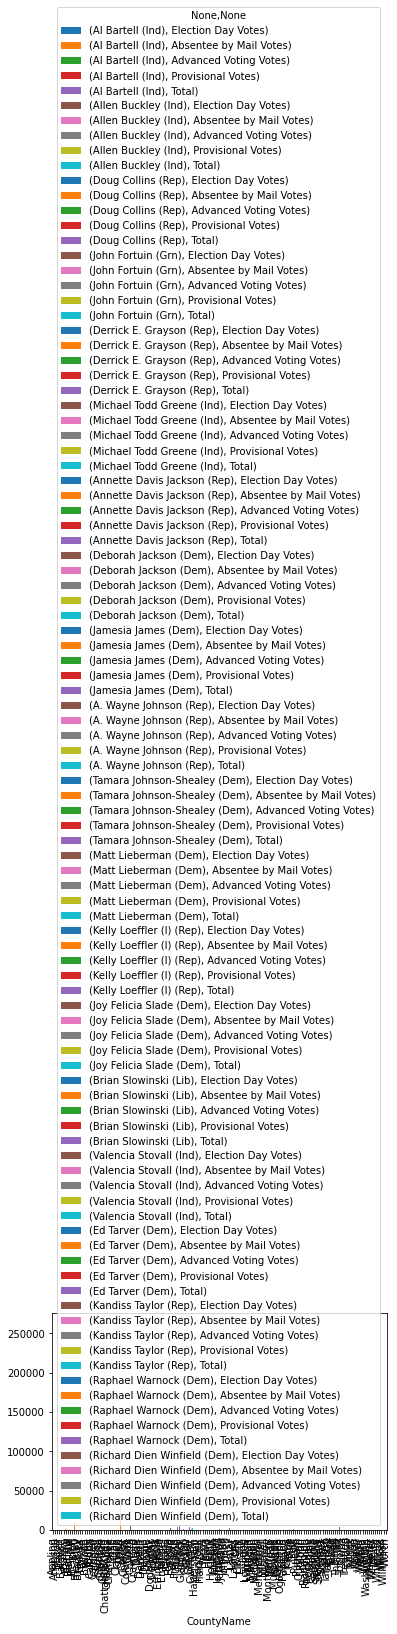

In [21]:
df = contests[list(contests.keys())[1]]
df.plot.bar()
plt.showplot()

In [ ]:
node.attrib.keys()
node.attrib['text']


## Voter Histoy
https://elections.sos.ga.gov/Elections/voterhistory.do

In [13]:
dpath = "./data/2020"
files = os.listdir(dpath)
fname = "2020.TXT"
if fname not in files:
    warnings.warn("{0} not found".format(fname))
if not os.path.isfile(os.path.join(dpath, fname)):
    warnings.warn("{0} not a file".format(fname))
with open(os.path.join(dpath, fname), mode='r') as fp:
    txt = fp.read()
voter_lines = txt.split('\n')
minlen = min([len(l) for l in voter_lines])
maxlen = max([len(l) for l in voter_lines])
print("{0} had {1} lines, minlen {2}, maxlen {3}".format(fname, len(voter_lines), minlen, maxlen))

2020.TXT had 8416980 lines, minlen 0, maxlen 27


In [ ]:
def parse_voter_lines(lines=None):
    from collections import namedtuple
    from collections import OrderedDict
    field_lens = {'county_num':3,
                'registration_num':8,
                'election_date':8,
                'election_type': 3,
                'party': 2,
                'absentee':1,
                'provisional':1,
                'supplemental':1}
    fields = ['county_num',
                'registration_num',
                'election_date',
                'election_type',
                'party',
                'absentee',
                'provisional',
                'supplemental']
    #print(field_lens.keys())
    VoterRec = namedtuple("VoterRec", fields )
    expected_len = sum([field_lens[k] for k in field_lens.keys()])
    tups = []
    #pdb.set_trace()
    for i, line in enumerate(lines):
        if len(line) != expected_len:
            msg = "{0} len={1}, line={2}".format(i, len(line), line)
            continue
        start = 0
        data = {}
        for f in fields:
            flen = field_lens[f]
            delem = line[start:(start+flen)]
            data[f] = delem
            start += flen
        vr = VoterRec(**data)
        tups .append(vr)
    df = pd.DataFrame(tups)
    return df, tups
df, tups = parse_voter_lines(lines=voter_lines)
print(tups[:2])
print(df.head())

In [2]:
fpath = os.path.join('.',"data")
fname = "County_Number_List.pdf"
# Creating a pdf file object.
pdf = open(fpath, mode="rb")
 
# Creating pdf reader object.
pdf_reader = PyPDF2.PdfFileReader(pdf)
 
# Checking total number of pages in a pdf file.
print("Total number of Pages:", pdf_reader.numPages)
 
# Creating a page object.
page = pdf_reader.getPage(200)
 
# Extract data from a specific page number.
print(page.extractText())
 
# Closing the object.
pdf.close()

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\jmull\\Documents\\Github\\ga-votes\\data'

In [6]:
# Election Types
election_types = {
    '001':'GENERAL PRIMARY',
    '002':'GENERAL PRIMARY RUN-OFF',
    '003':'GENERAL',
    '004':'GENERAL ELECTION RUNOFF',
    '005':'SPECIAL ELECTION',
    '006':'SPECIAL RUNOFF',
    '007':'NON- PARTISAN',
    '008':'SPECIAL/NON-PARTISAN',
    '009': ' RECALL',
    '010': 'PPP'
    #SPECIAL PRIMARY RUNOFF
    #SPECIAL PRIMARY
    }

In [8]:
gcols = ['election_date', 'election_type']
df.groupby(gcols).count()

county_num  registration_num    party  absentee  \
election_date election_type                                                    
20200128      005                  4881              4881     4881      4881   
20200204      005                 11940             11940    11940     11940   
20200303      006                  3705              3705     3705      3705   
20200324      005                   310               310      310       310   
              010                292247            292247   292247    292247   
20200519      005                     2                 2        2         2   
20200609      001               2362521           2362521  2362521   2362521   
              005                   280               280      280       280   
20200811      002                673178            673178   673178    673178   
20200929      005                 34812             34812    34812     34812   
20201103      003               5002772           5002772  5002772   5002772   
              005                  3604              3604     3604      3604   
20201201      004                 14170             14170    14170     14170   
              006                 12503             12503    12503     12503   
              009                    53                53       53        53   
20201204      003                     1                 1        1         1   

                             provisional  supplemental  
election_date election_type                             
20200128      005                   4881          4881  
20200204      005                  11940         11940  
20200303      006                   3705          3705  
20200324      005                    310           310  
              010                 292247        292247  
20200519      005                      2             2  
20200609      001                2362521       2362521  
              005                    280           280  
20200811      002                 673178        673178  
20200929      005                  34812         34812  
20201103      003                5002772       5002772  
              005                   3604          3604  
20201201      004                  14170         14170  
              006                  12503         12503  
              009                     53            53  
20201204      003                      1             1

In [19]:
fpath = os.path.join(os.getcwd(),"data")
fname = "County_Number_List.pdf"
if not os.path.isfile(os.path.join(fpath, fname)):
    if not os.path.isdir(fpath):
        warnings.warn("{0} not a directory".format(fpath))
    elif fname not in os.listdir(fpath):
        warnings.warn("{0} not a file in {1}".format(fname, fpath))
table = tabula.read_pdf(fpath,pages=1)
table[0]

Error from tabula-java:
Error: C:\Users\jmull\Documents\Github\ga-votes\data (Access is denied)




CalledProcessError: Command '['java', '-Dfile.encoding=UTF8', '-jar', 'C:\\Users\\jmull\\anaconda3\\lib\\site-packages\\tabula\\tabula-1.0.4-jar-with-dependencies.jar', '--pages', '1', '--guess', '--format', 'JSON', 'C:\\Users\\jmull\\Documents\\Github\\ga-votes\\data']' returned non-zero exit status 1.